In [1]:
import numpy as np
import pickle
import optuna
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

In [2]:
# Load training data of 0 digit samples
with open('digit_0_train.pkl', 'rb') as f:
    digit_0_train = pickle.load(f)  # List of tuples (image, label)
# Load full test set
with open('full_test.pkl', 'rb') as f:
    full_test = pickle.load(f)  # Tuple (x_test, y_test) for the full test dataset


test_images, test_labels = full_test
train_images, train_labels = zip(*digit_0_train)

# Reshape data to be 28x28x1 and normalize pixel values
train_images = np.array(train_images).reshape((-1, 28, 28, 1)) / 255.0
train_labels = np.array(train_labels)
test_images = np.array(test_images).reshape((-1, 28, 28, 1)) / 255.0
test_labels = np.array(test_labels)

In [ ]:
# Define Optuna trail for hyper-parameter optimization
def objective(trial):
    # Load the pre-trained model
    model = load_model('base_cnn_model.keras')
    
    # Define hyperparameters to optimize
    learning_rate = trial.suggest_float('learning_rate', .0000001, .0001, log=True)
    epochs = trial.suggest_int('epochs', 5, 30)
    
    # Freeze early layers
    for layer in model.layers[:-4]:
        layer.trainable = False
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    history = model.fit(
        train_images, train_labels,
        epochs=epochs,
        validation_split=0.2,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
        verbose=0
    )
    
    # Evaluate on test set
    _, test_acc = model.evaluate(test_images, test_labels, verbose=0)

    return test_acc

# Create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # 100 trails

print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value:.4f}')
print('  Params:')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

In [ ]:
# Train model with best hyperparameters
best_lr = study.best_params['learning_rate']
best_epochs = study.best_params['epochs']

# Load fresh model
model = load_model('base_cnn_model.keras')

# Freeze early layers
for layer in model.layers[:-4]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=best_lr),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_images, train_labels,
    epochs=best_epochs,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Evaluate accuracy on the full test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Final test accuracy: {test_acc:.4f}')

In [6]:
# Saved model full test accuracy: 0.9822
model.save('sequential_fine-tuned_model.keras')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9799 - loss: 0.0965
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Full test accuracy: 0.9822
Accuracy for digit 0: 0.9786


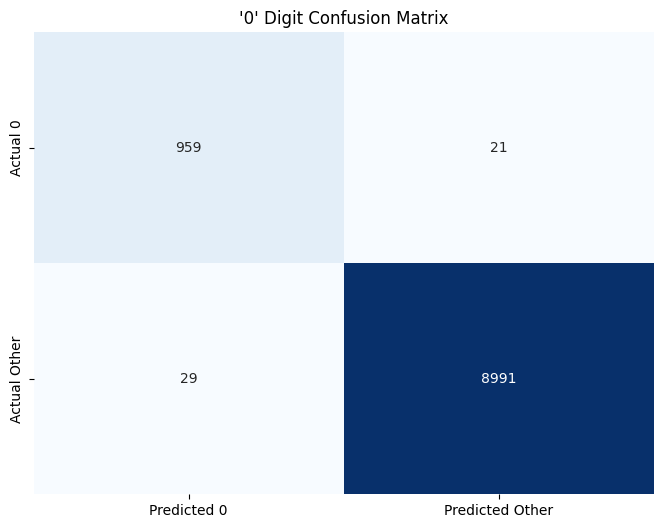

In [5]:
# Full test accuracy
_, test_acc = model.evaluate(test_images, test_labels)

# Accuracy for just digit '0'
# Get predictions for all test data
y_pred = np.argmax(model.predict(test_images), axis=1)

# Find indices of digit '0' in test set
zero_indices = np.where(test_labels == 0)[0]
zero_images = test_images[zero_indices]
zero_true_labels = test_labels[zero_indices]

# Get predictions for digit '0' samples
zero_pred = np.argmax(model.predict(zero_images), axis=1)

# Calculate accuracy for digit '0'
zero_accuracy = accuracy_score(zero_true_labels, zero_pred)

print(f'Full test accuracy: {test_acc:.4f}')
print(f'Accuracy for digit 0: {zero_accuracy:.4f}')

# Calculate number of false positives, false negatives, true positives, and true negatives for digit '0'
false_positives = np.sum((y_pred == 0) & (test_labels != 0))
false_negatives = np.sum((y_pred != 0) & (test_labels == 0))
true_positives = np.sum((y_pred == 0) & (test_labels == 0))
true_negatives = np.sum((y_pred != 0) & (test_labels != 0))

# Set up confusion matrix structure
conf_matrix = np.array([[true_positives, false_negatives], [false_positives, true_negatives]])

# Create confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted Other'], 
            yticklabels=['Actual 0', 'Actual Other'], 
            cbar=False)
plt.title("'0' Digit Confusion Matrix")
plt.show()